# Long Short‑Term Memory (LSTM)‑Driven Deep Learning Method for Spam Classification

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

### 2. Load and inspect dataset

The dataset named "SMS Spam Collection" was downloaded from https://archive.ics.uci.edu/dataset/228/sms+spam+collection and saved to a local directory before being uploaded to this notebook. 

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

 label
ham     4825
spam     747
Name: count, dtype: int64

 label
ham     87.0
spam    13.0
Name: proportion, dtype: float64


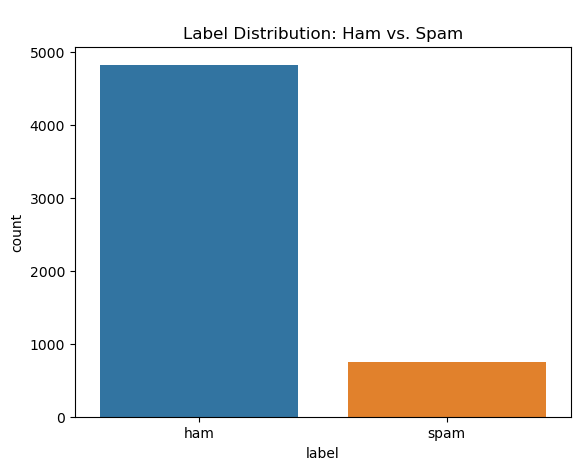

In [2]:
# Load data
df = pd.read_csv(
    'SMSSpamCollection', 
    sep='\t', # The SMS Spam Collection dataset is tab‑separated text file with no header
    header=None, 
    names=['label', 'text'] # This assigns column names manually, where label contains "ham" or "spam" and text contains the SMS message
) 

print(df.head())

# Check class imbalance
counts = df['label'].value_counts()
print('\n', counts)
percentage = df['label'].value_counts(normalize=True).mul(100).round(0)
print('\n', percentage)

# Visualize label distribution
ax0 = sns.countplot(data=df, x='label', hue='label')
ax0.set_title('\nLabel Distribution: Ham vs. Spam');

### 3. Encode labels and prepare features/targets

In [3]:
# Encode labels using Label Encoder: ham -> 0, spam -> 1
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Check encoded labels
print(df)

# Prepare feature (input text) and label/larget (output)
X = df['text'].values       
y = df['label_encoded'].values 

     label                                               text  label_encoded
0      ham  Go until jurong point, crazy.. Available only ...              0
1      ham                      Ok lar... Joking wif u oni...              0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...              1
3      ham  U dun say so early hor... U c already then say...              0
4      ham  Nah I don't think he goes to usf, he lives aro...              0
...    ...                                                ...            ...
5567  spam  This is the 2nd time we have tried 2 contact u...              1
5568   ham               Will ü b going to esplanade fr home?              0
5569   ham  Pity, * was in mood for that. So...any other s...              0
5570   ham  The guy did some bitching but I acted like i'd...              0
5571   ham                         Rofl. Its true to its name              0

[5572 rows x 3 columns]


### 4. Split into training and test sets

In [4]:
# Split the data before tokenization to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y # Here, 'stratify=y' keeps the spam/ham ratio similar in both sets.
) 

print('Train size:', len(X_train))
print('Test size:', len(X_test))

Train size: 4457
Test size: 1115


### 5. Tokenize the text (fit only on training data)

In [5]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer(oov_token="<OOV>") # <OOV> (stands for “Out‑Of‑Vocabulary") is a special placeholder token used to handle rare/unseen words
tokenizer.fit_on_texts(X_train)  # fit ONLY on training texts
 
# Convert words into sequences 
X_train_seq = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)

### 6. Pad sequences to a fixed length

In [6]:
# Check maximum sequence length, but it has no use in padding or model input
max_seq_len = max(len(seq) for seq in X_train_seq)
print('Maximum Sequence Length:', max_seq_len)

# Set a maximum limit to sequence length
max_len = 50

X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=max_len,
    padding='post', # padding='post' → add zeros after the sequence
    truncating='post' # truncating='post' → cut off extra tokens after the sequence
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

print("\nPadded train shape:", X_train_pad.shape)
print("Padded test shape:", X_test_pad.shape)

Maximum Sequence Length: 189

Padded train shape: (4457, 50)
Padded test shape: (1115, 50)


### 7. Build the LSTM based deep learning model

In [7]:
# Compute vocabulary size 
vocab_size = len(tokenizer.word_index) + 1 
print("Vocabulary size:", vocab_size)

# Choose the embedding dimension
embedding_dim = 64 # Represent each word/token as a 64‑dimensional vector (64 as a balanced/good default choice)

# Build a sequential LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(LSTM(64))
model.add(Dropout(0.5)) # Randomly drops 50% of the neurons in this layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # outputs spam probability between 0 and 1

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Vocabulary size: 7935


### 8. Train the model

Class weights: {0: np.float64(0.577481212749417), 1: np.float64(3.7265886287625416)} 

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8459 - loss: 0.5823 - val_accuracy: 0.9238 - val_loss: 0.2668
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9636 - loss: 0.2409 - val_accuracy: 0.9686 - val_loss: 0.1521
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9890 - loss: 0.1398 - val_accuracy: 0.9821 - val_loss: 0.0959
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9913 - loss: 0.1089 - val_accuracy: 0.9798 - val_loss: 0.1301
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9935 - loss: 0.0658 - val_accuracy: 0.9821 - val_loss: 0.0772
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9948 - loss: 0.0829 - val_accuracy: 0.9776 - val_loss: 0.1530
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9915 - loss: 0.0479 - val_accuracy: 0.9798 - val_loss: 0.1292
Epoch 8/10
63/63 ━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 64)              │         507,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,628,933 (6.21 MB)

 Trainable params: 542,977 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,085,956 (4.14 MB)

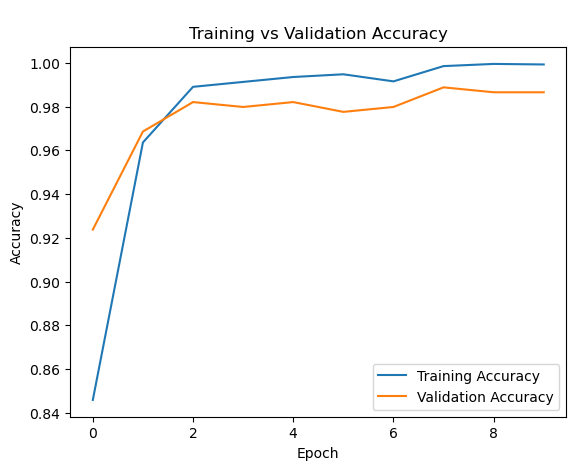

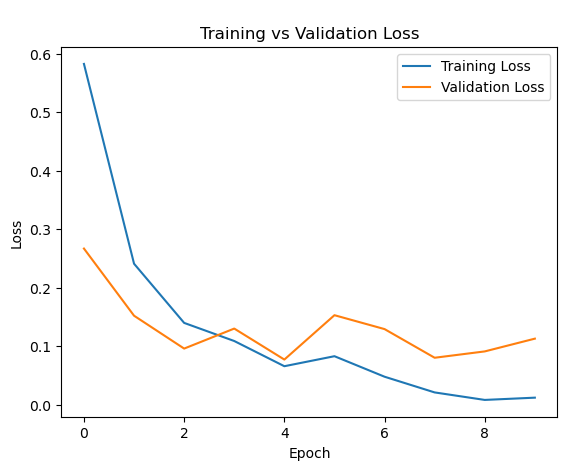

In [8]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {i: class_weights[i] for i in range(len(class_weights))} 
print("Class weights:", class_weights, '\n')

# Set training hyperparameters
batch_size = 64
epochs = 10  

# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,  # 10% of training data for validation
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    verbose=1
)

# Save the entire trained model
model.save("spam_lstm_model.keras")

# Save the tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print('\n')

model.summary()

# Visualize training vs. validation accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
plt.title('\nTraining vs Validation Accuracy') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show()

# Visualize training vs. validation loss curve
plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('\nTraining vs Validation Loss') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

### 9. Evaluate the spam detection performance

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.94      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix:
 [[957   9]
 [ 10 139]]


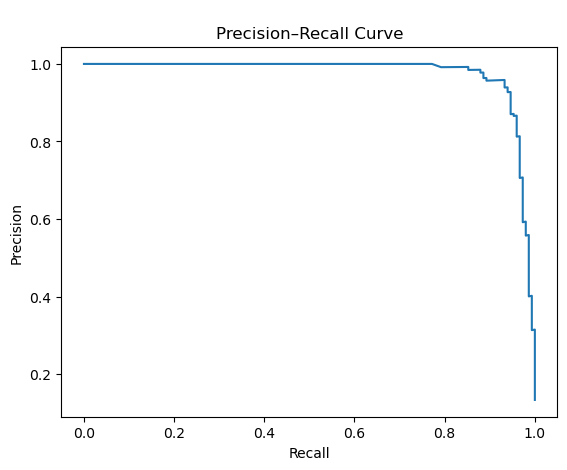

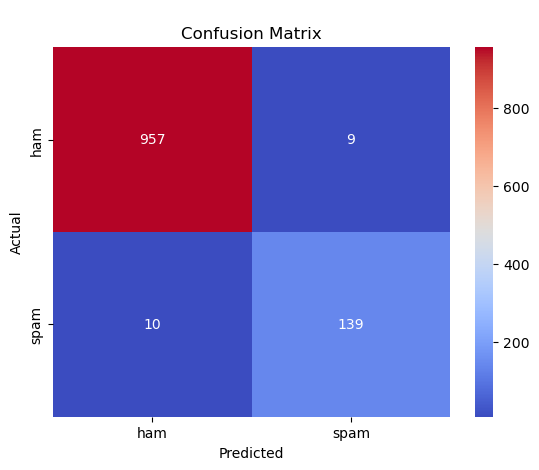

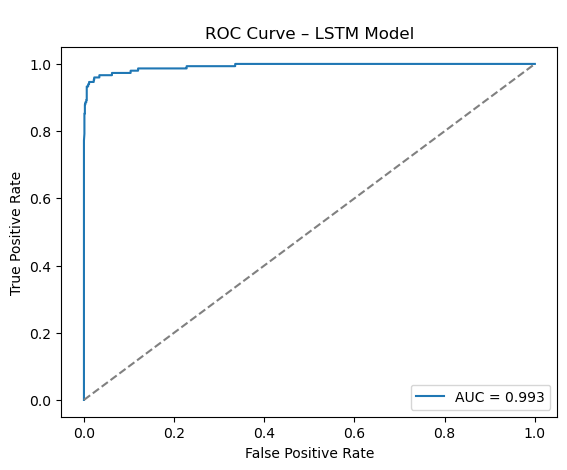

In [9]:
# Load the saved model
model = load_model('spam_lstm_model.keras')

# Load the saved tokenizer
import pickle
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Predict probabilities on the test set
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to class labels (0/1) using 0.5 threshold
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob) 
plt.plot(recall, precision) 
plt.title('\nPrecision–Recall Curve') 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.show()

# Visualize confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(data=cm, cmap='coolwarm', fmt='d', annot=True, xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display ROC curve + AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}') 
plt.plot([0,1], [0,1], linestyle='--', color='gray') 
plt.title('\nROC Curve – LSTM Model') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend() 
plt.show()

### 10. Use the model to classify new messages

In [10]:
def predict_message(msg):
    seq = tokenizer.texts_to_sequences([msg])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    prob = model.predict(pad)[0][0]
    label = "spam" if prob > 0.5 else "ham"
    return label, float(prob)

# Example messages
examples = [
    "Congratulations! You have won a free ticket. Click here to claim.",
    "Hi, just checking if you’re coming to class tomorrow.",
    "URGENT: Your account will be suspended. Verify your bank details now!"
]

for m in examples:
    label, prob = predict_message(m)
    print(f"Message: {m}\nPrediction: {label} (spam probability = {prob:.3f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Message: Congratulations! You have won a free ticket. Click here to claim.
Prediction: spam (spam probability = 1.000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Message: Hi, just checking if you’re coming to class tomorrow.
Prediction: ham (spam probability = 0.000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Message: URGENT: Your account will be suspended. Verify your bank details now!
Prediction: spam (spam probability = 1.000)

